<a href="https://colab.research.google.com/github/helonayala/bah/blob/main/B%26H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sysidentpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error
from scipy.io import loadmat
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation


In [3]:
!ls sample_data/

anscombe.json		      malha_fechada2.mat     README.md
california_housing_test.csv   mnist_test.csv	     seqDegrausFixo2.mat
california_housing_train.csv  mnist_train_small.csv  seqDegrausRand2.mat


##Plotando entrada e saída

###Degrau aleatório

In [4]:
mat1 = loadmat('/content/sample_data/seqDegrausRand2.mat')
df1 = pd.DataFrame(mat1['u'], columns=['u'])
df1['y'] = mat1['y']
print(df1)

        u         y
0     0.0  0.001967
1     0.0  0.001967
2     0.0  0.017270
3     0.0  0.012169
4     0.0  0.001967
...   ...       ...
8145  0.0  0.017270
8146  0.0  0.001967
8147  0.0  0.001967
8148  0.0  0.007068
8149  0.0  0.007068

[8150 rows x 2 columns]


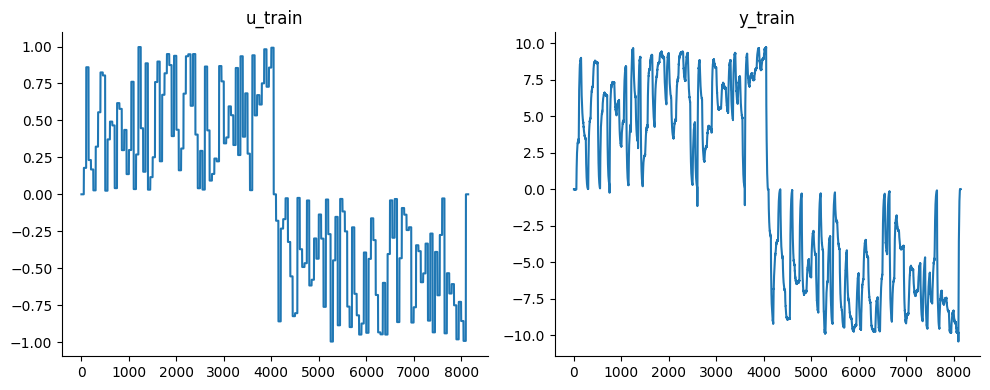

In [5]:
y_train= mat1['y']
u_train = mat1['u']

n_train = len(y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(u_train)
ax[0].set_title('u_train')

ax[1].plot(y_train)
ax[1].set_title('y_train')

plt.tight_layout()
plt.show()

###Degrau fixo

In [6]:
mat2 = loadmat('/content/sample_data/seqDegrausFixo2.mat')
df2 = pd.DataFrame(mat2['u'], columns=['u'])
df2['y'] = mat2['y']
print(df2)

        u         y
0     0.0  0.001967
1     0.0  0.007068
2     0.0  0.001967
3     0.0  0.012169
4     0.0  0.001967
...   ...       ...
2145  0.0  0.001967
2146  0.0  0.001967
2147  0.0  0.001967
2148  0.0  0.001967
2149  0.0  0.001967

[2150 rows x 2 columns]


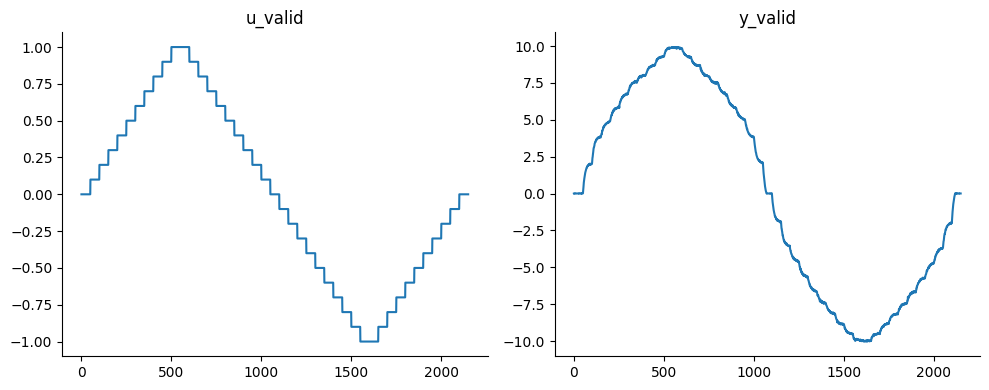

In [7]:
y_valid = mat2['y']
u_valid = mat2['u']
n_valid = len(y_valid)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(u_valid)
ax[0].set_title('u_valid')

ax[1].plot(y_valid)
ax[1].set_title('y_valid')

plt.tight_layout()
plt.show()

###Malha fechada

In [8]:
mat3 = loadmat('/content/sample_data/malha_fechada2.mat')
df3 = pd.DataFrame(mat3['u'], columns=['u'])
df3['y'] = mat3['y']
print(df3)

             u         y
0    -0.006971  0.017270
1    -0.002517  0.001967
2    -0.008890  0.017270
3    -0.000319 -0.008236
4    -0.005674  0.007068
...        ...       ...
2145  0.027808 -0.008236
2146  0.026571 -0.003135
2147  0.024825  0.001967
2148  0.024629  0.001967
2149  0.024432  0.001967

[2150 rows x 2 columns]


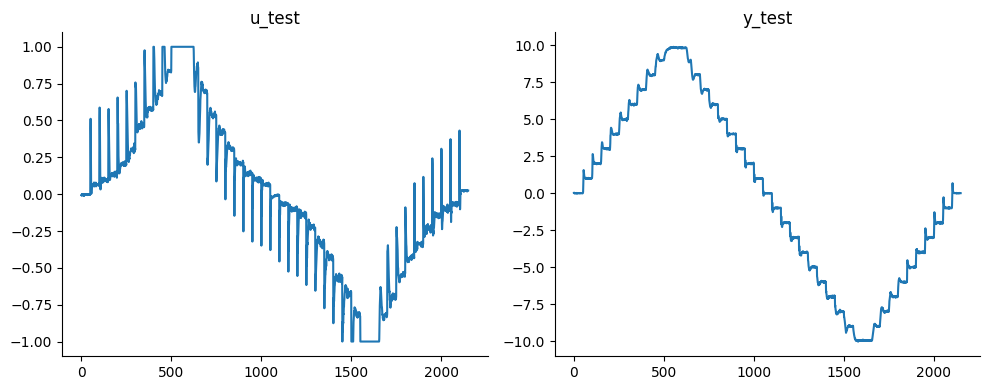

In [9]:
y_mf= mat3['y']
u_mf = mat3['u']

n_mf = len(y_mf)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(u_mf)
ax[0].set_title('u_test')

ax[1].plot(y_mf)
ax[1].set_title('y_test')

plt.tight_layout()
plt.show()

##Normalização dos dados

In [10]:
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

###Degrau aleatório

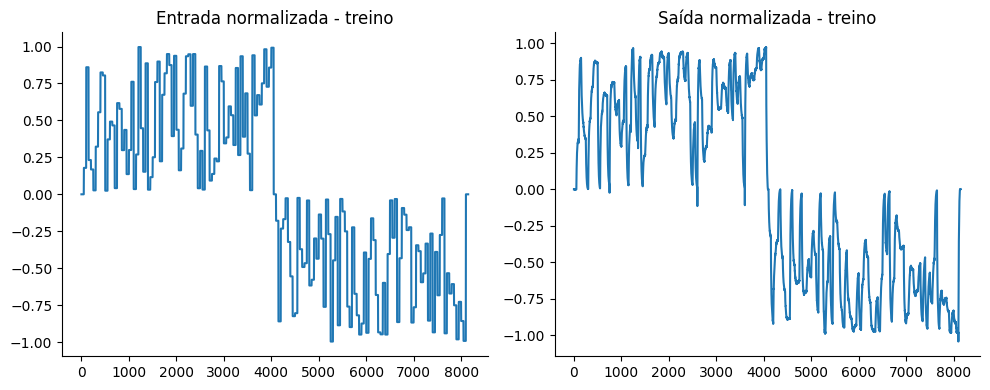

In [11]:
x_train_norm = u_train.flatten()
y_train_norm = (y_train/10).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(x_train_norm)
ax[0].set_title('Entrada normalizada - treino')

ax[1].plot(y_train_norm)
ax[1].set_title('Saída normalizada - treino')

plt.tight_layout()
plt.show()

In [12]:
print(x_train_norm.shape)
print(n_train)

(8150,)
8150


###Degrau fixo

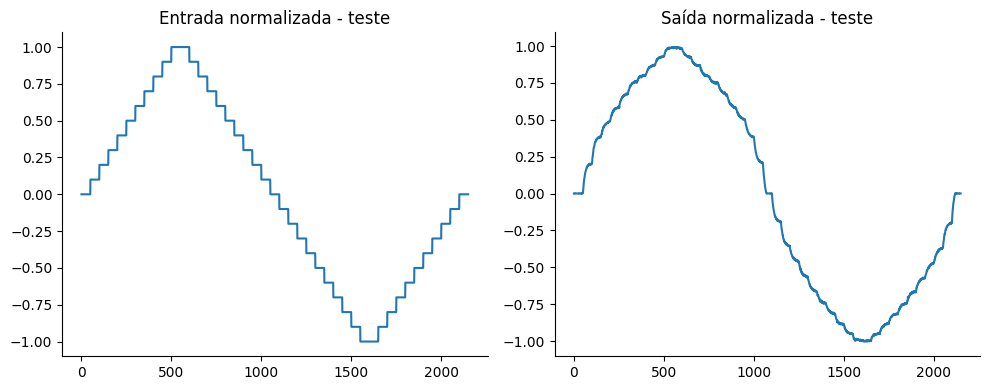

In [13]:
x_test_norm = u_valid.flatten()
y_test_norm = (y_valid/10).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(x_test_norm)
ax[0].set_title('Entrada normalizada - teste')

ax[1].plot(y_test_norm)
ax[1].set_title('Saída normalizada - teste')

plt.tight_layout()
plt.show()

In [14]:
print(x_test_norm.shape)
print(n_valid)

(2150,)
2150


###Malha fechada

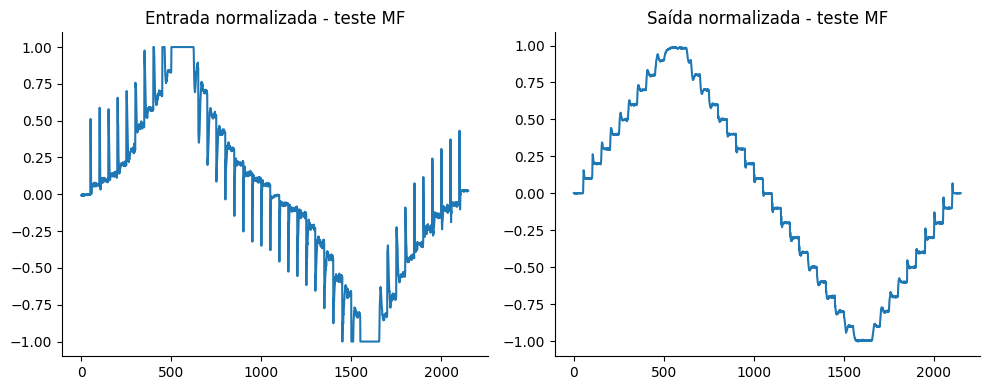

In [15]:
x_testmf_norm = u_mf.flatten()
y_testmf_norm = (y_mf/10).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(x_testmf_norm)
ax[0].set_title('Entrada normalizada - teste MF')

ax[1].plot(y_testmf_norm)
ax[1].set_title('Saída normalizada - teste MF')

plt.tight_layout()
plt.show()

##ANN

In [16]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense

In [17]:
# set random seed (reproducibility)
rseed = 42
np.random.seed(rseed)
tf.random.set_seed(rseed)
# print precision
np.set_printoptions(precision=3)

###Matriz de regressão e free run

In [18]:
def matReg(y,u,ny,nu):

    p = np.max((ny,nu)) + 1
    N = len(y)
    Nu = len(u)

    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)

    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)

        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input,verbose=0)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):]

In [19]:
ny = 3
nu = 2 # model orders

ye = y_train_norm
ue = x_train_norm
yt1 = y_test_norm
ut1 = x_test_norm
yt2 = y_testmf_norm
ut2 = x_testmf_norm
(Ye,Phie) = matReg(ye,ue,ny,nu)
(Yt1,Phit1) = matReg(yt1,ut1,ny,nu) #degrau
(Yt2,Phit2) = matReg(yt2,ut2,ny,nu) #malha fechada

###Modelo

In [36]:
_ , ninp = Phie.shape
nout = 1
nneu = 20 # how many neurons per layer

# model definition
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden2)
#hidden4 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden3)
output = keras.layers.Dense(nout)(hidden3)

model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [37]:
history = model.fit(Phie, Ye, epochs=3, batch_size = 32)

Epoch 1/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0063
Epoch 2/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0992e-04
Epoch 3/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8339e-04


In [38]:
# One step ahead
yhat = model.predict(Phie)
yhat1 = model.predict(Phit1)
yhat2 = model.predict(Phit2)

mse = mean_squared_error(ye, yhat)
mse1 = mean_squared_error(yt1, yhat1)
mse2 = mean_squared_error(yt2, yhat2)

R2test1  = r2_score(Yt1, yhat1)
R2test2  = r2_score(Yt2, yhat2)
R2train1 = r2_score(Ye, yhat)

print("\n-------------- One Step Ahead --------------")
print(f"R² Test 1: {R2test1}")
print(f"MSE Test 1: {mse1}")
print(f"R² Test 2: {R2test2}")
print(f"MSE Test 2: {mse2}")
print(f"R² Train: {R2train1}")
print(f"MSE Train: {mse}")

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

-------------- One Step Ahead --------------
R² Test 1: 0.9997023499817841
MSE Test 1: 0.943818671348679
R² Test 2: 0.9989817877167717
MSE Test 2: 0.7216826727961991
R² Train: 0.9993030463076792
MSE Train: 0.8740657923482069


###Free run

In [39]:
# y_train_pred0 = freeRun(model,ye,ue,ny,nu)
y_test_pred1  = freeRun(model,yt1,ut1,ny,nu)
y_test_pred2  = freeRun(model,yt2,ut2,ny,nu)

# R2train0 = r2_score(Ye, y_train_pred0)
R2test1  = r2_score(Yt1, y_test_pred1)
R2test2  = r2_score(Yt2, y_test_pred2)

print('-------------- Free Run  --------------')
print('R2test1 - degrau fixo  =')
print(R2test1)
print('R2test2 - malha fechada =')
print(R2test2)
# print('R2train0 - degrau aleatório=')
# print(R2train0)

<ipython-input-18-924323d395b9>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat[k-1] = model.predict(fr_input,verbose=0)


-------------- Free Run  --------------
R2test1 - degrau fixo  =
0.9917510059687912
R2test2 - malha fechada =
0.9860723031976352


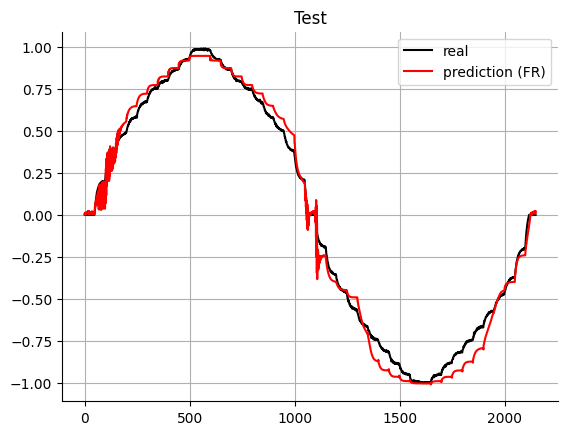

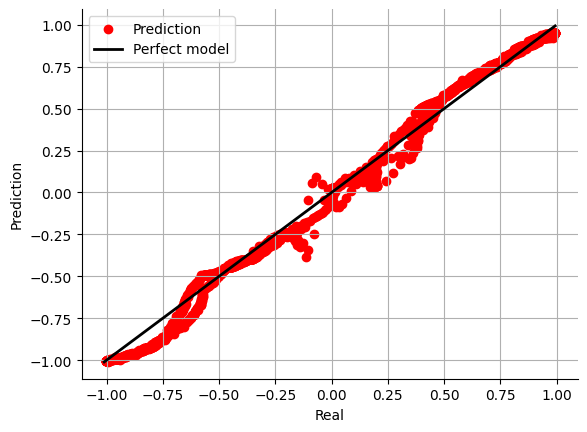

In [40]:
plt.figure()
plt.plot(Yt1,'k',y_test_pred1,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt1),min(y_test_pred1))
maxY = max(max(Yt1),max(y_test_pred1))
plt.scatter(Yt1,y_test_pred1,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()

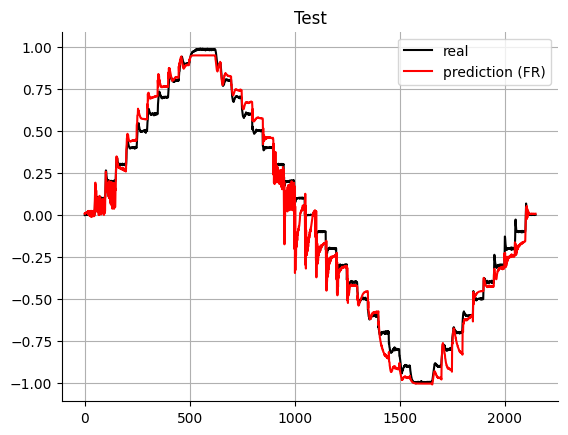

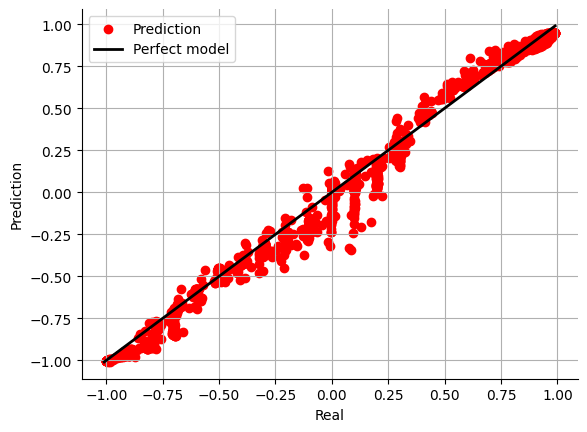

In [41]:
plt.figure()
plt.plot(Yt2,'k',y_test_pred2,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt2),min(y_test_pred2))
maxY = max(max(Yt2),max(y_test_pred2))
plt.scatter(Yt2,y_test_pred2,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()